# Tomographic Reconstruction
Tomography is the creation of an image from the projection data associated with cross-sectional scans of an object. 
X-rays project a 2D map of on object's density from a given angle. Reconstructing the 3D object from these projections can be achieved by using the inverse radon transform. We can obtain 

In [1]:
import numpy as np
import skimage.transform
import scipy as sp
import scipy.ndimage
import matplotlib.pyplot as plt
import os
import nibabel as nib
from scipy.fftpack import fft, fftshift, ifft

In [2]:
# Load Chest_ct.nii using nibabel

# source: http://nipy.org/nibabel/gettingstarted.html
script_path = os.path.dirname(os.path.realpath("__file__"))
# "__file__" doesn't return the directory where file is located, but just return the current working directory (where python is called).).
# __file__ on the other hand does return the directory where the file is located, but doesn't work in interactive mode
print(f"PATH:\n{script_path}")
example_filename = os.path.join(script_path, 'Chest_ct.nii')
img = nib.load(example_filename)

# To save a .nii file:
# my_slice = img.slicer[35]
# my_slice.to_filename(os.path.join(script_path, 'slice.nii'))

# transform nibabel image into numpy array
print(f"Type of img: {type(img)}")
print(f"Shape of img: {img.shape}")  # (512, 512, 76) - 76 slices of 2D pictures
np_img = img.get_fdata()
print(f"Type of np_img: {type(np_img)}")
print(f"Shape of np_img: {np_img.shape}")

PATH:
/Users/basilerommes/Dropbox/Documents/Master_UCPH/Year_2/Block_1/MIA/assign1
Type of img: <class 'nibabel.nifti1.Nifti1Image'>
Shape of img: (512, 512, 76)
Type of np_img: <class 'numpy.ndarray'>
Shape of np_img: (512, 512, 76)


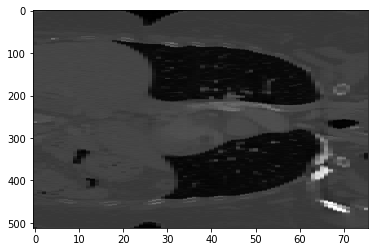

In [3]:
# coronal example
plt.figure(100)
plt.imshow(np_img[:, 256, :], aspect='auto', cmap='gray')
plt.show()

## Showing the CT from different agles along the subject's vertical axis

In [4]:
# # we project via the y axis, onto the (x,z) plane i.e. the coronal plane
# # anatomical to cartesian plane conversion:
# # sagital = (y,z) = (1,2)
# # coronal = (x,z) = (0,2)
# # transversal = (x,y) = (0,1)

projs = []
fig=plt.figure(figsize=(100,100))
rows = 4
columns = 3
for i in range(12):
    theta = i*30
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title(f"{theta} degrees", fontsize=130)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.tick_params(labelbottom=False)
    plt.tight_layout()
    # does spline interpolation
    rot_img = skimage.transform.rotate(np_img, angle=theta).astype('float64')  # axes=(1, 1, 0) would be logical but it is (1, 0)
    # make a projection onto the coronal (frontal) plane
    proj = rot_img.sum(axis=1)
    projs.append(proj)
    plt.imshow(proj, aspect='auto', cmap='gray')

plt.title("coronal view of torso, rotated by...")
plt.savefig(f"pictures/skimage_projections.pdf")
#plt.figure(0)

## View of transversal slice number 25 before transform

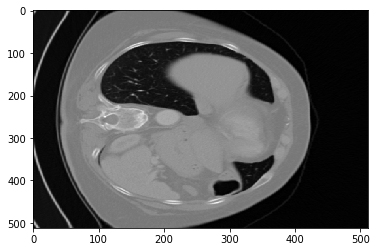

In [5]:
# discuss: look up aspect = 'auto'
slice25 = np_img[:, :, 24]
slice25.shape
plt.imshow(slice25, aspect='auto', cmap='gray')
plt.savefig(f"pictures/slice25.pdf")

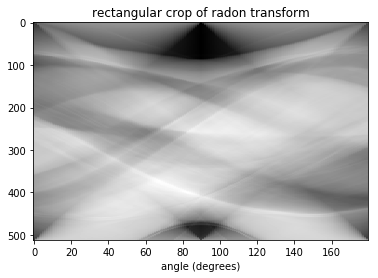

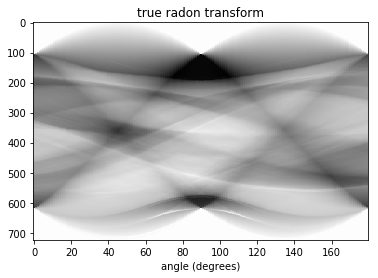

In [6]:
# inspired through: https://gist.github.com/fubel/ad01878c5a08a57be9b8b80605ad1247

# rotations without resize and padding, resulting in lost data at both ends of the projections
def discrete_radon_transform(image, steps):
    "Calculates sinogram of image by taking each horizontal pixel line"
    sinogram = np.zeros((len(image), steps), dtype='float64') ## image used to be np_img
    for s in range(steps):
        rot_img = skimage.transform.rotate(image, angle=s).astype('float64')
        #rotation = misc.imrotate(image, -s*180/steps).astype('float64')
        # summing over the horizontal pixels turned by angle s. This corresponds to a projection as given by X-ray.
        sinogram[:, s] = np.sum(rot_img, axis=1)
    return sinogram

# smart rotations conserving data
def discrete_radon_transform2(image, steps):
    imgLen = image.shape[0] #len(imgage) # gives shape[0]
    # the diagonal of the original image is the width of the image rotated by 90 degree. This is the biggest our rotImg can ever get
    diagLen = int(np.sqrt(len(np_img)**2 + len(np_img)**2))
    sinogram = np.zeros((diagLen, steps), dtype='float64')
    for s in range(steps):
        # the size of the rotated image depends on the rotation and so can vary in this case from 512 to 724 (diagLen)
        # the projection "lines" that are smaller than diagLen have to be padded equally to fit
        rot_img = skimage.transform.rotate(image, angle=s, resize=True).astype('float64')
        rotImgLen = rot_img.shape[0]
        #padding, steps = # of rotations
        #rotation = misc.imrotate(image, -s*180/steps).astype('float64')
        # number of zeroes you are padding left and padding right have to add up to (imgLen - rotImgLen)
        # the padding to the left is at the same time the padding to the top and right is also bottom
        #print(diagLen)
        pad_l = int(np.ceil((diagLen - rotImgLen)/2))
        pad_r = int(np.floor((diagLen - rotImgLen)/2))
        #print(pad_l, pad_r)
        padded_rot = np.pad(rot_img, ((pad_l,pad_r), (pad_l,pad_r)), mode='constant', constant_values=((0,0),(0,0)))
        #print(padded_rot.shape)
        proj = np.sum(padded_rot, axis=1)
        sinogram[:, s] = proj
    return sinogram

#fig = plt.subplots(1,2)
naive_sinogram = discrete_radon_transform(slice25, 180)
plt.imshow(naive_sinogram, aspect="auto", cmap="gray")
plt.title("rectangular crop of radon transform")
plt.xlabel("angle (degrees)")

plt.show()

#plt.figure(2)
sinogram = discrete_radon_transform2(slice25, 180)
plt.imshow(sinogram, aspect="auto", cmap="gray")
plt.xlabel("angle (degrees)")
plt.title("true radon transform")

plt.savefig("pictures/sinogram.pdf")
sinogram.shape
plt.show()
# check through reference implementation
#skimage.transform.radon(image, theta=1, circle=True)
#skimage.transform.radon(image, theta=1, circle=False)

# rot_img = sp.ndimage.interpolation.rotate(img, angle=30, axes=(1,1,0))
#
# print(rot_img.shape)
#
# rot_img.to_filename(os.path.join(script_path, 'slice.nii'))

# write what interpolation method you are using when rotating!!

# check your results with a reference implementation!

"The Radon transform data is often called a sinogram because the Radon transform of an off-center point source is a sinusoid." <br/> source: https://en.wikipedia.org/wiki/Radon_transform

## Backpropagation
For the backprojection, which also bears the name 'inverse radon transform', we proceed in a reverse
manner than before: for each column in the sinogram (i.e. for each projection), the column vector
is repeated horizontally until it ts the desired size and the resulting matrix is rotated clockwise
by the same angle it was originally rotated counter clockwise. We sum up over all matrices created
this way and obtain the reconstructed image, surrounded by some noise created by the padding
during the radon transform. To get rid of the padding artefact, we crop the centre of the image
such as to regain the original image size (512  512 pixel).

The method used here is dubbed "filtered backprojection".

For more details, see:
https://en.wikipedia.org/wiki/Tomographic_reconstruction#Reconstruction_algorithms

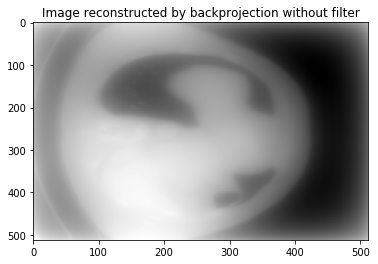

In [7]:
def my_backproject(sinogram, angles):
    imageLen = sinogram.shape[0]
    
    projMatrix = np.zeros((imageLen, imageLen))
    for i, theta in enumerate(angles):
        # initialize empty
        proj = sinogram[:, i]
        #rot_projection = skimage.transform.rotate(proj, angle=-theta).astype('float64')
        #
        zeroMat = np.zeros((imageLen, imageLen))
        #print(int(np.round(imageLen/2)))
        #print(zeroMat.shape, proj.shape)
        # this puts the vector in the middle of the matrix, but we want to copy it instead
        #zeroMat[:, int(np.round(imageLen/2))] = proj
        #matrified = zeroMat
        
        #np.repeat(rot_projection, (imageLen, 1))
        # Ndarray 'matrix-vector' addition copies the 'row vector' vertically so they have the same dimensions, and then adds all entries pairwise
        matrified = zeroMat + proj
        
        # because we needed to repeat the vector horizontally, but ndarrays are by default row vectors, we have to transpose proj into column vectors (or transpose 'matrified', it doesn't matter)
        matrifiedT = matrified.T
        
        rotProj = skimage.transform.rotate(matrifiedT, angle=-theta).astype('float64')
        projMatrix += rotProj
        # axes=(1, 1, 0) would be logical but it is (1, 0) 
    # crop to get back initial dimensions
    border_l = int(np.ceil((imageLen-512)/2))
    border_r = int(np.floor((imageLen-512)/2))
    projMatrix = projMatrix[border_l:imageLen-border_r, border_l:imageLen-border_r]
    return projMatrix

reconMatrix = my_backproject(sinogram, np.arange(180))
plt.imshow(reconMatrix, cmap='gray', aspect='auto')
plt.title("Image reconstructed by backprojection without filter")
plt.savefig("pictures/recon_img.pdf")
plt.show()
plt.close()

In [8]:
def ssd(X, Y):
    """ Normalize input 2D arrays via min-max normalization, then on the normalized arrays,
    compute the sum of squared differences. Divide by the number of pixels N to get a normalized value."""
    assert(X.shape == Y.shape)
    N = X.size
    X_normalized = (X-np.min(X))/(np.max(X)-np.min(X))
    Y_normalized = (Y-np.min(Y))/(np.max(Y)-np.min(Y))
    return np.sum((X_normalized-Y_normalized)**2)/N


#def ssd_alt(X, Y):
#    """ Alternative method to normalize input 2D arrays via min-max normalization, then on the normalized arrays,
#    compute the sum of squared differences. Divide by the number of pixels N to get a normalized value.
#    
#    Note that this is equal to the method ssd since max(X-X_min) = X_max - X_min"""
#    assert(X.shape == Y.shape)
#    N = X.size
#    X_shift = X-np.min(X)
#    X_normalized = X_shift/np.max(X_shift)
#    Y_shift = Y-np.min(Y)
#    Y_normalized = Y_shift/np.max(Y_shift)
#    return np.sum((X_normalized-Y_normalized)**2)/N


print(ssd(slice25, reconMatrix))
#print(ssd_alt(slice25, reconMatrix))

0.09746801775978726


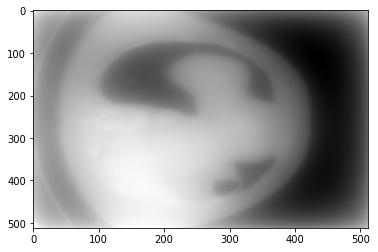

0.09746801775978726

In [9]:
filtered_sino = discrete_radon_transform2(slice25, 180)
fbp = my_backproject(filtered_sino, range(180))
plt.imshow(fbp, cmap='gray', aspect='auto')
plt.show()
ssd(slice25, fbp)

In [17]:
def my_arange(start, stop=None, step=1):
    """Modified version of numpy.arange which corrects error associated with non-integer step size.
    Tthis ensures that the last entry returned by my_arange is excluded, which is needed because 
    -π and π are the same angle on the trigonometric circle"""
    if stop == None:
        a = np.arange(start)
    else:
        a = np.arange(start, stop, step)
        if a[-1] > stop-step:   
            a = np.delete(a, -1)
    return a

print(np.arange(0, 1, 0.4))
print(my_arange(0, 1, 0.4))

[0.  0.4 0.8]
[0.  0.4]


In [18]:
#shifted = fftshift(sinogram)
#plt.imshow(shifted1, cmap='gray', aspect='auto')
#plt.show()
#shifted_back = fftshift(shifted)
#plt.imshow(shifted_back, cmap='gray', aspect='auto')
#plt.show()

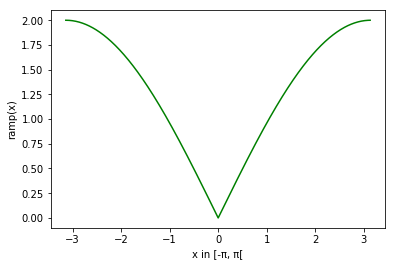

In [29]:
def ramp(x, a=1):
    """The ramp function we use to filter the backprojection corresponds to the absolute value in frequency domain,
    and to a wavelet function in fourrier domain.
    
    abs(x) constitutes a high-pass filter.
    
    1. The unfiltered backprojection has a high density in the center (-> white area in the middle) and 2. is blurred.
    Multiplying by ramp filter takes out low frequencies which solves 1.
    
    inputs: x - argument
    a - argument scaling parameter, controls curvature of ramp, gives number of bows of ramp function
    
    outputs: |2/a * sin(a * w/2)|"""
    return abs(2/a * np.sin(a * w/2))

projLen, numAngles = sinogram.shape
step = 2*np.pi/projLen
w = np.arange(-np.pi, np.pi, step)

plt.plot(w, ramp(w), "g-")
plt.xlabel("x in [-π, π[")
plt.ylabel("ramp(x)")
plt.show()


In [22]:
import pdb

def projFilter(sino):
    """filter projections. Normally a ramp filter multiplied by a window function is used in filtered
    backprojection. The filter function here can be adjusted by a single parameter 'a' to either approximate
    a pure ramp filter (a ~ 0)  or one that is multiplied by a sinc window with increasing cutoff frequency (a ~ 1).
    Credit goes to Wakas Aqram. 
    inputs: sino - [n x m] numpy array where n is the number of projections and m is the number of angles used.
    outputs: filtSino - [n x m] filtered sinogram array"""
    
    projLen, numAngles = sino.shape
    stepsize = 2*np.pi/projLen  # each projection comes at a different angle of the circle (2π)
    w = np.arange(-np.pi, np.pi, stepsize)  # proceed from 'east' of the circle to 'south', 'west', 'north' and eventually 'east' again
    if len(w) < projLen:
        w = np.concatenate([w, [w[-1]+stepsize]]) # depending on image size, it might be that len(w) =  
                                                  # projLen - 1. Another element is added to w in this case
    r = ramp(w) #abs(2*np.sin(w/2));
    
    filt = fftshift(r)  # apply fourrier transform to filter
    filtSino = np.zeros((projLen, numAngles))  # initialize zero-array
    for i in range(numAngles):
        fftProj = fft(sino[:,i])  # apply fourrier transfor to each single projection
        filtProj = fftProj*filt  # apply ramp filter to projection
        # apply inverse fourrier transform to filtered projection.
        # the imaginary part of the projection is not of interest to us
        filtSino[:,i] = np.real(ifft(filtProj))

    return filtSino

def my_projFilter(sino):
    """
    Applies filter to sinogram. For why a filtered is needed when backprojecting, see:
    https://www.clear.rice.edu/elec431/projects96/DSP/filters.html
    
    input: sino - [n x m] numpy array where n is the number of projections and m is the number of angles used.
    output: filtSino - [n x m] filtered sinogram array
    """
    projLen, numAngles = sino.shape # 512, 180
    
    # shift the sinogram, divides the sinogram into equal-sized quarters, 
    # then swaps each quarter with it's diagonal  counterpart
    shifted_sino = fftshift(sino)
    plt.imshow(sino, cmap='gray', aspect='auto')
    plt.show()
    plt.imshow(shifted_sino, cmap='gray', aspect='auto')
    plt.show()
    
    # initialize empty matrix for the filtered sinogram
    filtSino = np.zeros((projLen, numAngles)) 
    
    step = 2*np.pi/projLen
    # make projLen number of stops in the range of [-π, +π[
    w = np.arange(-np.pi, np.pi, step)

    if len(w) < projLen:
        # w[-1]+step add another step to the last element
        # depending on image size, it might be that len(w) =  
        # projLen-1. Another element is added to w in this case
        w = np.concatenate([w, [w[-1]+step]])
        print(w[-1]) # see the added element. it should be pi
        print(np.pi-step + step)
    
    # apply ramp filter to w
    rampfilter = ramp(w)
    # shift it because????
    shifted_rampfilter = fftshift(rampfilter)
    print(f"shifted rampfilter: {shifted_rampfilter}")
    for i in range(numAngles):
        
        projfft = fft(shifted_sino[:,i]) # fast fourrier-transform the projections
        
        # apply your choice of high-pass filter to the projections in fourrier-space
        # I went with the straight-forward Ram-Lak/ramp filter, which is the absolute value function
        # it's not good at dealing with noise, however it does get rid of blur and centered density effect
        filtProj = projfft * shifted_rampfilter
        # we are only interested in the real part of the complex fourrier result
        filtSino[:, i] = np.real(ifft(filtProj))
    return filtSino

(724,)
(724,)


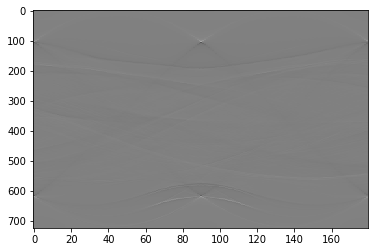

In [23]:
filtered_sino = projFilter(sinogram) # my_projFilter(sinogram)
plt.imshow(filtered_sino, cmap='gray', aspect='auto')
plt.show()

In [24]:
bp = my_backproject(sinogram, range(180))
fbp = my_backproject(filtered_sino, range(180))

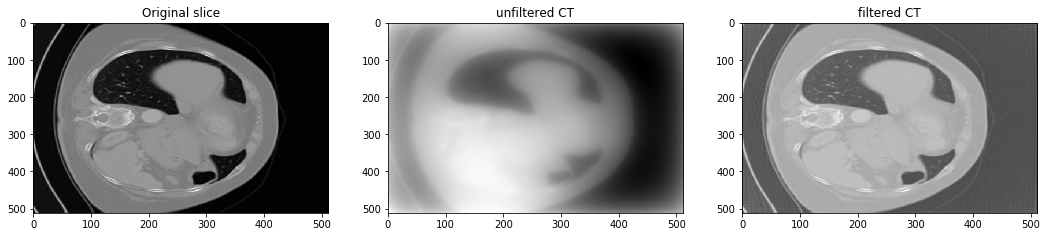

sum of squares deviation: unfiltered backprojection vs original:
 0.0975
sum of squares deviation: filtered backrpojection vs original:
 0.0581


In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 3.5))

plt.sca(ax1)
plt.imshow(slice25, cmap='gray', aspect='auto')
plt.title("Original slice")
#plt.show()

plt.sca(ax2)
plt.imshow(bp, cmap='gray', aspect='auto')
plt.title("unfiltered CT") # Radon transformed and reconstruction by inverse radon transform
#plt.show()

plt.sca(ax3)
plt.imshow(fbp, cmap='gray', aspect='auto')
plt.title("filtered CT")
plt.show()
#plt.show()

print(f"sum of squares deviation: unfiltered backprojection vs original:\n {ssd(slice25, bp):.4f}")
print(f"sum of squares deviation: filtered backrpojection vs original:\n {ssd(slice25, fbp):.4f}")